In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.8 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel
from sklearn.preprocessing import OneHotEncoder
import tqdm
import torch.optim as optim

data = pd.read_csv("protein_data.tsv.gz", sep="\t")
data = data[data["Length"] <= 256] # removes all proteins with a length > 256
# Reduce EC number to 3 digits to decrease data size
data = data.dropna(subset=['EC number']).assign(
    ec_number_reduced = lambda x: x['EC number'].str.split(".").str[:3].str.join(".")
)


<ipython-input-4-8545c0cecae5>:10: DtypeWarning: Columns (12,15,16,18,19,21,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("protein_data.tsv.gz", sep="\t")


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

encoder = OneHotEncoder(sparse=False)
encoded_column = encoder.fit_transform(data[["ec_number_reduced"]])

# Split data into 80% training data and 20% testing data
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]
train_labels = encoded_column[:train_size]
test_labels = encoded_column[train_size:]

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
train_dataset = CustomDataset(train_data["Sequence"].tolist(), train_labels)
test_dataset = CustomDataset(test_data["Sequence"].tolist(), test_labels)

# Used to combine data into batches
def collate_fn(batch):
    proteins = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    return tokenizer(proteins, padding=True), torch.tensor(labels)

batch_size = 8
# Put data into batches
train_dataloader = DataLoader(train_dataset, batch_size, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, collate_fn=collate_fn, shuffle=True)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
class MyModel(nn.Module):
    def __init__(self, esm_model, num_classes):
        super(MyModel, self).__init__()
        self.esm_model = esm_model
        for param in self.esm_model.parameters():
            param.requires_grad = False
        # Four layers: 320, 200, 128, num_classes
        self.fc_layers = nn.Sequential(nn.Linear(320, 200),
                                       nn.ReLU(),
                                       nn.Linear(200, 128),
                                       nn.ReLU(),
                                       nn.Linear(128, num_classes))

    def forward(self, input_ids, attention_mask):
        outputs = self.esm_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        pool = torch.mean(outputs.hidden_states[-1], dim=1)
        logits = self.fc_layers(pool)
        probs = torch.softmax(logits, dim=1)
        return logits, probs

num_classes = len(set(data["ec_number_reduced"].tolist()))
esm_model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = MyModel(esm_model, num_classes).to("cuda")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
learning_rate = 0.0001
epochs = 100
early_stop_count = 5
min_loss_improvement = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()
losses = []
accuracies = []
top_5_accuracies = []

best_loss = float("inf")
no_improvement_count = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm.tqdm(train_dataloader):
        inputs = torch.tensor(batch[0]["input_ids"]).to("cuda")
        attention_masks = torch.tensor(batch[0]["attention_mask"]).to("cuda")
        labels = batch[1].to("cuda")

        optimizer.zero_grad()
        logits, probs = model(inputs, attention_masks)
        loss = loss_function(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch}, loss: {average_loss:.4f}")
    losses.append(average_loss)

    # Accuracy
    model.eval()

    correct = 0
    total = 0
    top_5_correct = 0
    top_5_total = 0

    with torch.no_grad():
        for batch in test_dataloader:
            inputs = torch.tensor(batch[0]["input_ids"]).to("cuda")
            attention_masks = torch.tensor(batch[0]["attention_mask"]).to("cuda")
            labels = batch[1].to("cuda")

            # Top-1 Accuracy
            logits, probs = model(inputs, attention_masks)
            pred_class = probs.argmax(-1).flatten()
            labels = labels.argmax(-1).flatten()
            correct += (pred_class == labels).sum().item()
            total += pred_class.shape[0]

            # Top-5 Accuracy
            pred_classes = probs.topk(5, dim=1)[1]

            for i in range(pred_classes.shape[0]):
                if labels[i] in pred_classes[i]:
                    top_5_correct += 1
                top_5_total += 1

    accuracy = correct / total * 100
    top_5_accuracy = top_5_correct / top_5_total * 100
    accuracies.append(accuracy)
    top_5_accuracies.append(accuracy)

    if best_loss - average_loss > min_loss_improvement:
        best_loss = average_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stop_count:
        break

  0%|          | 0/7292 [00:00<?, ?it/s]<ipython-input-5-3e41ac34c91f>:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return tokenizer(proteins, padding=True), torch.tensor(labels)
100%|██████████| 7292/7292 [03:40<00:00, 33.02it/s]


Epoch 0, loss: 2.7484


100%|██████████| 7292/7292 [03:38<00:00, 33.32it/s]


Epoch 1, loss: 1.6598


100%|██████████| 7292/7292 [03:38<00:00, 33.32it/s]


Epoch 2, loss: 1.3131


100%|██████████| 7292/7292 [03:38<00:00, 33.37it/s]


Epoch 3, loss: 1.1154


100%|██████████| 7292/7292 [03:37<00:00, 33.45it/s]


Epoch 4, loss: 0.9800


100%|██████████| 7292/7292 [03:39<00:00, 33.24it/s]


Epoch 5, loss: 0.8804


100%|██████████| 7292/7292 [03:40<00:00, 33.10it/s]


Epoch 6, loss: 0.8013


100%|██████████| 7292/7292 [03:40<00:00, 33.00it/s]


Epoch 7, loss: 0.7369


100%|██████████| 7292/7292 [03:40<00:00, 33.01it/s]


Epoch 8, loss: 0.6850


100%|██████████| 7292/7292 [03:40<00:00, 33.01it/s]


Epoch 9, loss: 0.6418


100%|██████████| 7292/7292 [03:39<00:00, 33.16it/s]


Epoch 10, loss: 0.6037


100%|██████████| 7292/7292 [03:38<00:00, 33.30it/s]


Epoch 11, loss: 0.5708


100%|██████████| 7292/7292 [03:38<00:00, 33.39it/s]


Epoch 12, loss: 0.5407


100%|██████████| 7292/7292 [03:38<00:00, 33.38it/s]


Epoch 13, loss: 0.5154


100%|██████████| 7292/7292 [03:37<00:00, 33.48it/s]


Epoch 14, loss: 0.4912


100%|██████████| 7292/7292 [03:39<00:00, 33.27it/s]


Epoch 15, loss: 0.4697


100%|██████████| 7292/7292 [03:39<00:00, 33.27it/s]


Epoch 16, loss: 0.4508


100%|██████████| 7292/7292 [03:39<00:00, 33.24it/s]


Epoch 17, loss: 0.4313


100%|██████████| 7292/7292 [03:39<00:00, 33.23it/s]


Epoch 18, loss: 0.4150


100%|██████████| 7292/7292 [03:39<00:00, 33.22it/s]


Epoch 19, loss: 0.4000


100%|██████████| 7292/7292 [03:38<00:00, 33.40it/s]


Epoch 20, loss: 0.3863


100%|██████████| 7292/7292 [03:38<00:00, 33.43it/s]


Epoch 21, loss: 0.3725


100%|██████████| 7292/7292 [03:38<00:00, 33.44it/s]


Epoch 22, loss: 0.3595


100%|██████████| 7292/7292 [03:38<00:00, 33.32it/s]


Epoch 23, loss: 0.3478


100%|██████████| 7292/7292 [03:38<00:00, 33.42it/s]


Epoch 24, loss: 0.3383


100%|██████████| 7292/7292 [03:38<00:00, 33.39it/s]


Epoch 25, loss: 0.3269


100%|██████████| 7292/7292 [03:37<00:00, 33.49it/s]


Epoch 26, loss: 0.3185


100%|██████████| 7292/7292 [03:38<00:00, 33.36it/s]


Epoch 27, loss: 0.3072


100%|██████████| 7292/7292 [03:38<00:00, 33.39it/s]


Epoch 28, loss: 0.2983


100%|██████████| 7292/7292 [03:37<00:00, 33.46it/s]


Epoch 29, loss: 0.2897


100%|██████████| 7292/7292 [03:37<00:00, 33.45it/s]


Epoch 30, loss: 0.2823


100%|██████████| 7292/7292 [03:37<00:00, 33.50it/s]


Epoch 31, loss: 0.2742


100%|██████████| 7292/7292 [03:38<00:00, 33.38it/s]


Epoch 32, loss: 0.2663


100%|██████████| 7292/7292 [03:38<00:00, 33.34it/s]


Epoch 33, loss: 0.2602


100%|██████████| 7292/7292 [03:40<00:00, 33.00it/s]


Epoch 34, loss: 0.2518


100%|██████████| 7292/7292 [03:40<00:00, 33.11it/s]


Epoch 35, loss: 0.2456


100%|██████████| 7292/7292 [03:39<00:00, 33.22it/s]


Epoch 36, loss: 0.2395


100%|██████████| 7292/7292 [03:39<00:00, 33.15it/s]


Epoch 37, loss: 0.2321


100%|██████████| 7292/7292 [03:39<00:00, 33.16it/s]


Epoch 38, loss: 0.2273


100%|██████████| 7292/7292 [03:40<00:00, 33.13it/s]


Epoch 39, loss: 0.2205


100%|██████████| 7292/7292 [03:39<00:00, 33.15it/s]


Epoch 40, loss: 0.2153


100%|██████████| 7292/7292 [03:39<00:00, 33.16it/s]


Epoch 41, loss: 0.2109


100%|██████████| 7292/7292 [03:40<00:00, 33.06it/s]


Epoch 42, loss: 0.2051


100%|██████████| 7292/7292 [03:39<00:00, 33.21it/s]


Epoch 43, loss: 0.1999


100%|██████████| 7292/7292 [03:38<00:00, 33.40it/s]


Epoch 44, loss: 0.1942


100%|██████████| 7292/7292 [03:38<00:00, 33.42it/s]


Epoch 45, loss: 0.1901


100%|██████████| 7292/7292 [03:39<00:00, 33.26it/s]


Epoch 46, loss: 0.1854


100%|██████████| 7292/7292 [03:38<00:00, 33.32it/s]


Epoch 47, loss: 0.1818


100%|██████████| 7292/7292 [03:40<00:00, 33.13it/s]


Epoch 48, loss: 0.1774


100%|██████████| 7292/7292 [03:40<00:00, 33.05it/s]


Epoch 49, loss: 0.1723


100%|██████████| 7292/7292 [03:41<00:00, 32.88it/s]


Epoch 50, loss: 0.1685


100%|██████████| 7292/7292 [03:41<00:00, 32.99it/s]


Epoch 51, loss: 0.1641


100%|██████████| 7292/7292 [03:41<00:00, 32.95it/s]


Epoch 52, loss: 0.1611


100%|██████████| 7292/7292 [03:40<00:00, 33.01it/s]


Epoch 53, loss: 0.1561


100%|██████████| 7292/7292 [03:42<00:00, 32.79it/s]


Epoch 54, loss: 0.1531


100%|██████████| 7292/7292 [03:40<00:00, 33.10it/s]


Epoch 55, loss: 0.1495


100%|██████████| 7292/7292 [03:40<00:00, 33.08it/s]


Epoch 56, loss: 0.1466


100%|██████████| 7292/7292 [03:40<00:00, 33.10it/s]


Epoch 57, loss: 0.1424


100%|██████████| 7292/7292 [03:39<00:00, 33.21it/s]


Epoch 58, loss: 0.1388


100%|██████████| 7292/7292 [03:39<00:00, 33.17it/s]


Epoch 59, loss: 0.1357


100%|██████████| 7292/7292 [03:39<00:00, 33.16it/s]


Epoch 60, loss: 0.1322


100%|██████████| 7292/7292 [03:40<00:00, 33.14it/s]


Epoch 61, loss: 0.1301


100%|██████████| 7292/7292 [03:40<00:00, 33.14it/s]


Epoch 62, loss: 0.1270


100%|██████████| 7292/7292 [03:40<00:00, 33.14it/s]


Epoch 63, loss: 0.1241


100%|██████████| 7292/7292 [03:40<00:00, 33.08it/s]


Epoch 64, loss: 0.1211


100%|██████████| 7292/7292 [03:40<00:00, 33.12it/s]


Epoch 65, loss: 0.1176


100%|██████████| 7292/7292 [03:40<00:00, 33.12it/s]


Epoch 66, loss: 0.1152


100%|██████████| 7292/7292 [03:40<00:00, 33.13it/s]


Epoch 67, loss: 0.1124


100%|██████████| 7292/7292 [03:40<00:00, 33.06it/s]


Epoch 68, loss: 0.1101


100%|██████████| 7292/7292 [03:39<00:00, 33.17it/s]


Epoch 69, loss: 0.1083


100%|██████████| 7292/7292 [03:39<00:00, 33.24it/s]


Epoch 70, loss: 0.1052


100%|██████████| 7292/7292 [03:40<00:00, 33.07it/s]


Epoch 71, loss: 0.1024


100%|██████████| 7292/7292 [03:40<00:00, 33.08it/s]


Epoch 72, loss: 0.0995


100%|██████████| 7292/7292 [03:39<00:00, 33.28it/s]


Epoch 73, loss: 0.0977


100%|██████████| 7292/7292 [03:38<00:00, 33.36it/s]


Epoch 74, loss: 0.0954


100%|██████████| 7292/7292 [03:38<00:00, 33.32it/s]


Epoch 75, loss: 0.0931


100%|██████████| 7292/7292 [03:38<00:00, 33.37it/s]


Epoch 76, loss: 0.0914


100%|██████████| 7292/7292 [03:38<00:00, 33.40it/s]


Epoch 77, loss: 0.0891


100%|██████████| 7292/7292 [03:38<00:00, 33.42it/s]


Epoch 78, loss: 0.0881


100%|██████████| 7292/7292 [03:37<00:00, 33.48it/s]


Epoch 79, loss: 0.0855


100%|██████████| 7292/7292 [03:38<00:00, 33.35it/s]


Epoch 80, loss: 0.0830


100%|██████████| 7292/7292 [03:38<00:00, 33.42it/s]


Epoch 81, loss: 0.0815


100%|██████████| 7292/7292 [03:39<00:00, 33.26it/s]


Epoch 82, loss: 0.0789


100%|██████████| 7292/7292 [03:38<00:00, 33.44it/s]


Epoch 83, loss: 0.0772


100%|██████████| 7292/7292 [03:38<00:00, 33.40it/s]


Epoch 84, loss: 0.0760


100%|██████████| 7292/7292 [03:38<00:00, 33.45it/s]


Epoch 85, loss: 0.0738


100%|██████████| 7292/7292 [03:39<00:00, 33.28it/s]


Epoch 86, loss: 0.0726


100%|██████████| 7292/7292 [03:38<00:00, 33.39it/s]


Epoch 87, loss: 0.0711


100%|██████████| 7292/7292 [03:38<00:00, 33.36it/s]


Epoch 88, loss: 0.0691


100%|██████████| 7292/7292 [03:38<00:00, 33.38it/s]


Epoch 89, loss: 0.0672


100%|██████████| 7292/7292 [03:38<00:00, 33.41it/s]


Epoch 90, loss: 0.0665


100%|██████████| 7292/7292 [03:38<00:00, 33.34it/s]


Epoch 91, loss: 0.0642


100%|██████████| 7292/7292 [03:38<00:00, 33.37it/s]


Epoch 92, loss: 0.0631


100%|██████████| 7292/7292 [03:39<00:00, 33.22it/s]


Epoch 93, loss: 0.0615


100%|██████████| 7292/7292 [03:39<00:00, 33.28it/s]


Epoch 94, loss: 0.0588


100%|██████████| 7292/7292 [03:38<00:00, 33.41it/s]


Epoch 95, loss: 0.0581


100%|██████████| 7292/7292 [03:38<00:00, 33.39it/s]


Epoch 96, loss: 0.0563


100%|██████████| 7292/7292 [03:37<00:00, 33.53it/s]


Epoch 97, loss: 0.0562


100%|██████████| 7292/7292 [03:36<00:00, 33.61it/s]


Epoch 98, loss: 0.0544


100%|██████████| 7292/7292 [03:38<00:00, 33.43it/s]


Epoch 99, loss: 0.0532


In [ ]:
model.eval()

correct = 0
total = 0

top_5_correct = 0
top_5_total = 0

class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for batch in tqdm.tqdm(test_dataloader):
        inputs = torch.tensor(batch[0]["input_ids"]).to("cuda")
        attention_masks = torch.tensor(batch[0]["attention_mask"]).to("cuda")
        labels = batch[1].to("cuda")

        # Top-1 Accuracy
        logits, probs = model(inputs, attention_masks)
        pred_class = probs.argmax(-1).flatten()
        labels = labels.argmax(-1).flatten()
        correct += (pred_class == labels).sum().item()
        total += pred_class.shape[0]

        # Top-5 Accuracy
        pred_classes = probs.topk(5, dim=1)[1]

        for i in range(pred_classes.shape[0]):
            if labels[i] in pred_classes[i]:
                top_5_correct += 1
            top_5_total += 1

        # Accuracy per class
        for i in range(labels.shape[0]):
            class_label = labels[i]
            class_correct[class_label] += (pred_class[i] == class_label).item()
            class_total[class_label] += 1

100%|██████████| 1823/1823 [01:18<00:00, 23.34it/s]


In [ ]:
accuracy = correct / total * 100
top_5_accuracy = top_5_correct / top_5_total * 100
print(f"Accuracy: {accuracy:.4f}")
print(f"Top-5 Accuracy: {top_5_accuracy:.4f}")

highest = 0
highest_idx = 0
for i in range(num_classes):
    if class_total[i] != 0:
        if class_correct[i] / class_total[i] > highest:
            highest = class_correct[i] / class_total[i]
            highest_idx = i

lowest = float("inf")
lowest_idx = 0
for i in range(num_classes):
    if class_total[i] != 0:
        if class_correct[i] / class_total[i] < lowest:
            lowest = class_correct[i] / class_total[i]
            lowest_idx = i

highest_accuracy = highest * 100
lowest_accuracy = lowest * 100
print(f"Highest Accuracy Label: {highest_idx}, Accuracy: {highest_accuracy:.4f}%")
print(f"Lowest Accuracy Label: {lowest_idx}, Accuracy: {lowest_accuracy:.4f}%")

Accuracy: 88.6786
Top-5 Accuracy: 95.0559
Highest Accuracy Label: 7, Accuracy: 100.0000%
Lowest Accuracy Label: 4, Accuracy: 0.0000%


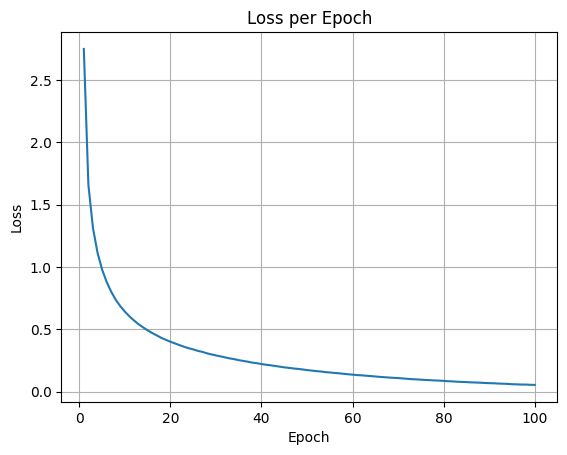

In [ ]:
import matplotlib.pyplot as plt

epochs_lst = list(range(1, len(losses)+1))

plt.plot(epochs_lst, losses)
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

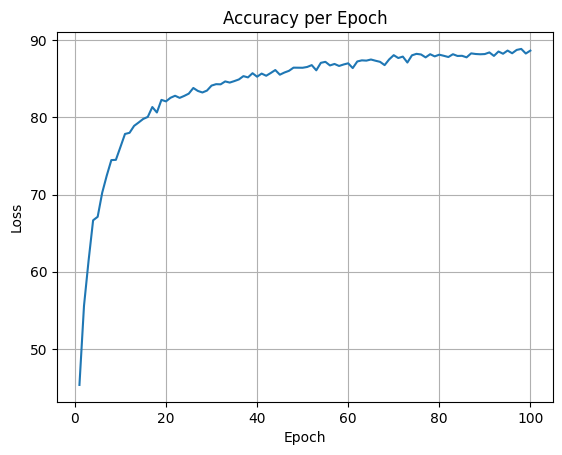

In [ ]:
plt.plot(epochs_lst, accuracies)
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
print(data["ec_number_reduced"].iloc[highest_idx])
print(data["ec_number_reduced"].iloc[lowest_idx])
print(class_total[highest_idx], class_total[lowest_idx])
print()
for i in range(num_classes):
    if class_correct[i] == 0 and class_total[i] != 0:
        print(data["ec_number_reduced"].iloc[i], class_total[i])

3.5.1
2.4.2
4 1

2.4.2 1
3.1.3 2
1.11.1 1
3.4.24 1
3.6.5 3
4.1.1 1
3.4.22 3
1.3.98 4
3.1.1 3
1.11.2 1
2.4.1 1
3.1.1 1
2.1.1 3
3.1.- 4
4.6.1 13
3.5.1 2
1.6.5 2
3.1.11 4
3.1.1 2
2.3.2 2
3.6.5 10
1.1.1 6
3.4.19 7
3.1.4 1
3.6.1 1
3.5.1 2
3.4.21 3
5.5.1 1
2.3.2 1
2.5.1 1
1.11.1 1
2.3.2 1
4.3.99 3
2.7.7 6
2.7.7 2
1.6.5 3
3.3.2 1
3.1.1 5


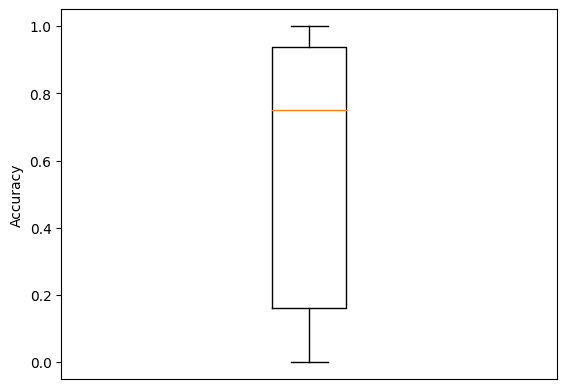

In [ ]:
class_accuracies = [0] * num_classes
for i in range(num_classes):
    if class_total[i] == 0:
        class_accuracies[i] = -1
    else:
        class_accuracies[i] = class_correct[i] / class_total[i]

class_accuracies.sort()
class_accuracies = [x for x in class_accuracies if x != -1]

plt.boxplot(class_accuracies)
plt.xticks([])
plt.ylabel("Accuracy")
plt.show()